# Sentiment Analysis

<a id="content"></a>
## Contents:
* [1. Dataset](#dataset)
    * [1.1. Loading Data](#loading)
    * [1.2. Data Preprocessing](#preprocessing)
    * [1.3. Dataset Visualization](#visualization)
    * [1.4. Vectorization](#vectorization)
* [2. Classifiers](#classifiers)
    * [2.1. Naive Bayes Classfication](#naive)
    * [2.2. K-Nearest Neighbour Classification](#KNN)
    * [2.3. Support Vector Machine (SVM) Classification](#SVM)
    * [2.4. Decision Tree Machine Classification](#DT)
* [3. Training & Evaluation](#training)
    * [3.1. Subjectivity](#subjectivity)
    * [3.2. Polarity](#polarity)
* [Advanced. Bert](#bert)

In [1]:
# Additional dependencies of BERT models
!pip install -q -U "tensorflow-text==2.8.*"
!pip install -q tf-models-official==2.7.0
!pip install wordcloud==1.8.2.2
!pip install imbalanced_learn==0.9.1
!pip install imblearn==0.0
!pip install langdetect==1.0.9
!pip install regex==2022.3.15

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tfx-bsl 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.8.3 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.8.3 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflow<3,>=2.9.0, but you have tensorflow 2.8.3 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow<2.7.0,>=2.6.0, but you have tensorflow 2.8.3 which is incompatible.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, but you have tensorflow-io-gcs-filesystem 0.27.0 which is incompatible.
pytorch-lightning 1.7.7 requires tensorboard>=2.9.1, but you have tensorboard 2.8.0 which is incompatible

In [2]:
# Import libraries
import ast
import pandas as pd
import numpy as np
import regex as re
import string
import os
import shutil
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import random
from tqdm import tqdm
tqdm.pandas()

# preprocessing 
import nltk
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from langdetect import detect
from langdetect import DetectorFactory
from imblearn.under_sampling import RandomUnderSampler

# word cloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
pd.options.mode.chained_assignment = None


from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier

import pickle # used to save model

# metrics
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 

# Below are for Bert 

# keras
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras import callbacks

import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer


# set seed for reproducibility
seed=42

<a id="dataset"></a>
## [1. Dataset Presentation](#content)

About data:<br>
Our dataset comprise of the following parts:
* Public Dataset:
    * [Twitter Sentiment on Gaming](https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis)
    * [Twitter Sentiment](https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset) 
    * [Steam Sentiment](https://www.kaggle.com/datasets/muhammadiqbalmukati/top10-steam-games-dataset) <br>
    All public datasets are transformed and merged into one large dataset with same sentiment label in advance.
* Crawled Dataset:
    * Twitter & Steam Sentiment on Gaming (Through scraping and manual labeling)
    

<a id="loading"></a>
### [1.1. Loading Data](#content)
Load necessary data.

In [3]:
# Removing unused columns
df_outside = pd.read_csv("dataset_transformed.csv", encoding='latin')
df_crawl = pd.read_csv("compiled_tweets.csv", encoding='latin')

df_outside = df_outside[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[["Text", "Subjectivity", "Polarity"]]
df_crawl = df_crawl[df_crawl['Subjectivity'].notna()].copy()
df = pd.concat([df_crawl, df_outside]).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23343 entries, 0 to 23342
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Text          23343 non-null  object 
 1   Subjectivity  23343 non-null  float64
 2   Polarity      15788 non-null  float64
dtypes: float64(2), object(1)
memory usage: 547.2+ KB


<a id="preprocessing"></a>
### [1.2. Data Preprocessing](#content)

As twitter texts are relatively unclean compared with others, special cleaning are applied to remove emojis and links

In [4]:
# set seed
DetectorFactory.seed = 0

def language_detection(x:str):
    text = x.split(" ")
    
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        except Exception as e:
            lang = "unknown"
            pass
    return lang

In [5]:
df['Language'] = df['Text'].progress_apply(language_detection)

100%|██████████| 23343/23343 [02:10<00:00, 179.09it/s]


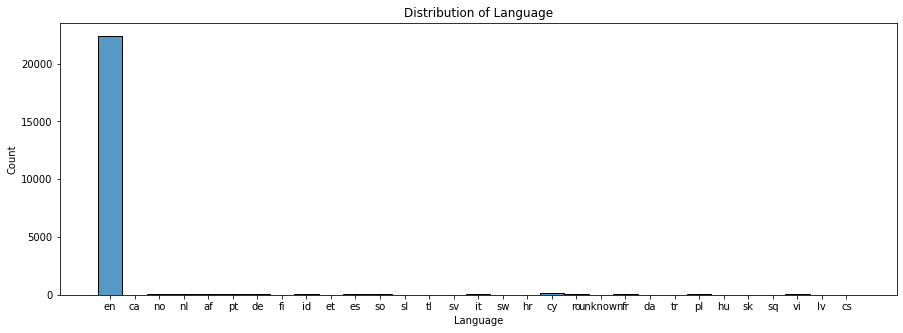

In [6]:
#plot the distribution of language
fig = plt.figure(figsize=(15, 5))
sns.histplot(data=df['Language'])
plt.title("Distribution of Language")
plt.show()

In [7]:
df = df[df['Language'] == 'en'].copy()

In [8]:
def clean_text(text):
    text = str(text)
    text = re.sub(r'[^a-zA-Z ]+', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    text = re.sub(r'^RT[\s]+', '', text)
    # text = re.sub(r'pic.twitter\S+', ' ', text)
    text = re.sub(r'#', '', text)
    text = text.lower()

    return text

def decontracted(text):
    text = re.sub(r"won\'t", "will not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"it\'s", "it is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)

    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"\“", "", text)
    text = re.sub(r"\”", "", text)
    text = re.sub(r"\…", "", text)

    return text


def remove_punc(tweet):
    tweet =  tweet.translate(str.maketrans('', '', string.punctuation))
    tweet = ' '.join([word for word in tweet.split()])
    tweet = tweet.lower()
    
    return tweet

In [9]:
df['Text'] = df['Text'].progress_apply(clean_text).apply(decontracted).apply(remove_punc)
df.head()

100%|██████████| 22391/22391 [00:01<00:00, 20687.42it/s]


,Text,Subjectivity,Polarity,Language
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en


#### Stopwords Removal

We should remove stopwards before stemming as our stop word list does not include specifications for stemming or lemmatizing

In [10]:
nltk.download('stopwords')
nltk.download('punkt')

stop = stopwords.words('english')
additional_stopwords = ["'s","...","'ve","``","''","'m",'--',"'ll","'d", 'u', 'b', 'c', 'd', 'x', 'xf', 'f', 'p', 'xb']
stop = set(stop + additional_stopwords)

def remove_stopwords(x):
    x = word_tokenize(x)
    store_words = ''
    
    for i in x:
        if i not in stop:
            store_words += i + ' '
            
    return store_words

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
df['cleaned_text'] = df['Text'].progress_apply(remove_stopwords)

df.head()

100%|██████████| 22391/22391 [00:04<00:00, 5128.24it/s]


,Text,Subjectivity,Polarity,Language,cleaned_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew went live twitch come chat hang...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,little bit dbd apex legends co fihcgnia
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex lets get damage co dbt givs...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgames go crazy apex follow carbo...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hopping apexlegends bit come want witness...


#### Stemming

In [12]:
def stem_text(x):
    stemmer = PorterStemmer()
    x = word_tokenize(x)
    stem = ''
    
    for i in x:
        stem += stemmer.stem(i) + ' '
        
    return stem

df['cleaned_stemmed_text'] = df['cleaned_text'].progress_apply(stem_text)
df.head()

100%|██████████| 22391/22391 [00:16<00:00, 1334.23it/s]


,Text,Subjectivity,Polarity,Language,cleaned_text,cleaned_stemmed_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,little bit dbd apex legends co fihcgnia,littl bit dbd apex legend co fihcgnia
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex lets get damage co dbt givs...,tuesday night apex let get damag co dbt givsyr...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgames go crazy apex follow carbo...,watch tohrmentgam go crazi apex follow carbong...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hopping apexlegends bit come want witness...,live hop apexlegend bit come want wit decent g...


#### Lemmatization

In [13]:
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatize_text(corpus):
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in tweet.split()]) for tweet in corpus]

df['cleaned_lemmatized_text'] = lemmatize_text(df['cleaned_text'])
df.head()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


,Text,Subjectivity,Polarity,Language,cleaned_text,cleaned_stemmed_text,cleaned_lemmatized_text
0,hey kingz crew i just went live on twitch come...,1.0,1.0,en,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...,hey kingz crew went live twitch come chat hang...
1,little bit of dbd into apex legends t co fihcg...,0.0,NaN,en,little bit dbd apex legends co fihcgnia,littl bit dbd apex legend co fihcgnia,little bit dbd apex legend co fihcgnia
2,tuesday night apex lets get some damage t co d...,1.0,1.0,en,tuesday night apex lets get damage co dbt givs...,tuesday night apex let get damag co dbt givsyr...,tuesday night apex let get damage co dbt givsy...
3,watch tohrmentgames go crazy on apex follow up...,1.0,1.0,en,watch tohrmentgames go crazy apex follow carbo...,watch tohrmentgam go crazi apex follow carbong...,watch tohrmentgames go crazy apex follow carbo...
4,live hopping into some apexlegends for a bit c...,0.0,NaN,en,live hopping apexlegends bit come want witness...,live hop apexlegend bit come want wit decent g...,live hopping apexlegends bit come want witness...


<a id="visualization"></a>
### [1.3. Data Visualization](#content)

In [14]:
print("========== number of words in the corpus ==========")

print(f"original: {df['Text'].apply(lambda x: len(x.split())).sum()}")

print(f"after removal of stopwords: {df['cleaned_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after stemming and removal of stopwords: {df['cleaned_stemmed_text'].apply(lambda x: len(x.split())).sum()}")

print(f"after lemmatization and removal of stopwords: {df['cleaned_lemmatized_text'].apply(lambda x: len(x.split())).sum()}")

========== number of words in the corpus ==========
original: 913857
after removal of stopwords: 504286
after stemming and removal of stopwords: 504286
after lemmatization and removal of stopwords: 504286


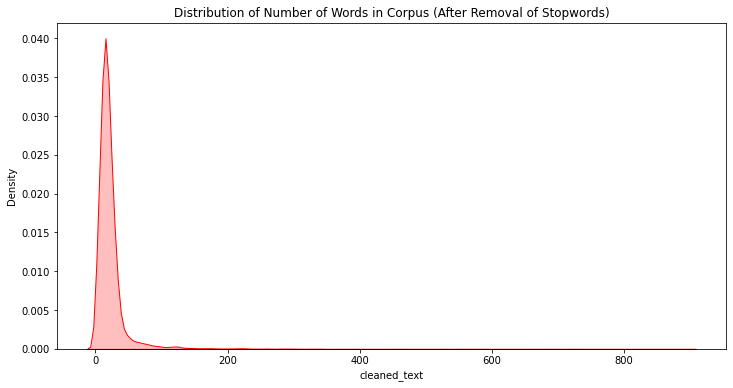

In [15]:
num_words_train = df['cleaned_text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(12,6))
p1=sns.kdeplot(df['cleaned_text'].apply(lambda x: len(x.split())), fill=True, color="r").set_title('Distribution of Number of Words in Corpus (After Removal of Stopwords)')

In [16]:
word_list_train = df.cleaned_text.str.split()
top = Counter([item for sublist in word_list_train for item in sublist])
temp = pd.DataFrame(top.most_common(15))
temp.columns = ['Common_words','count']
temp.style.background_gradient(cmap='Blues')

,Common_words,count
0,game,15455
1,modi,4165
2,play,4119
3,like,3882
4,get,3559
5,good,3008
6,fun,2729
7,time,2713
8,one,2504
9,people,2388


In [17]:
def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100, figure_size=(24.0,16.0), color = 'white',
                   title = None, title_size=40, image_color=False):

    wordcloud = WordCloud(background_color=color,
                    stopwords = STOPWORDS,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = seed,
                    width=400, 
                    height=200,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask)
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear")
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud)
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()

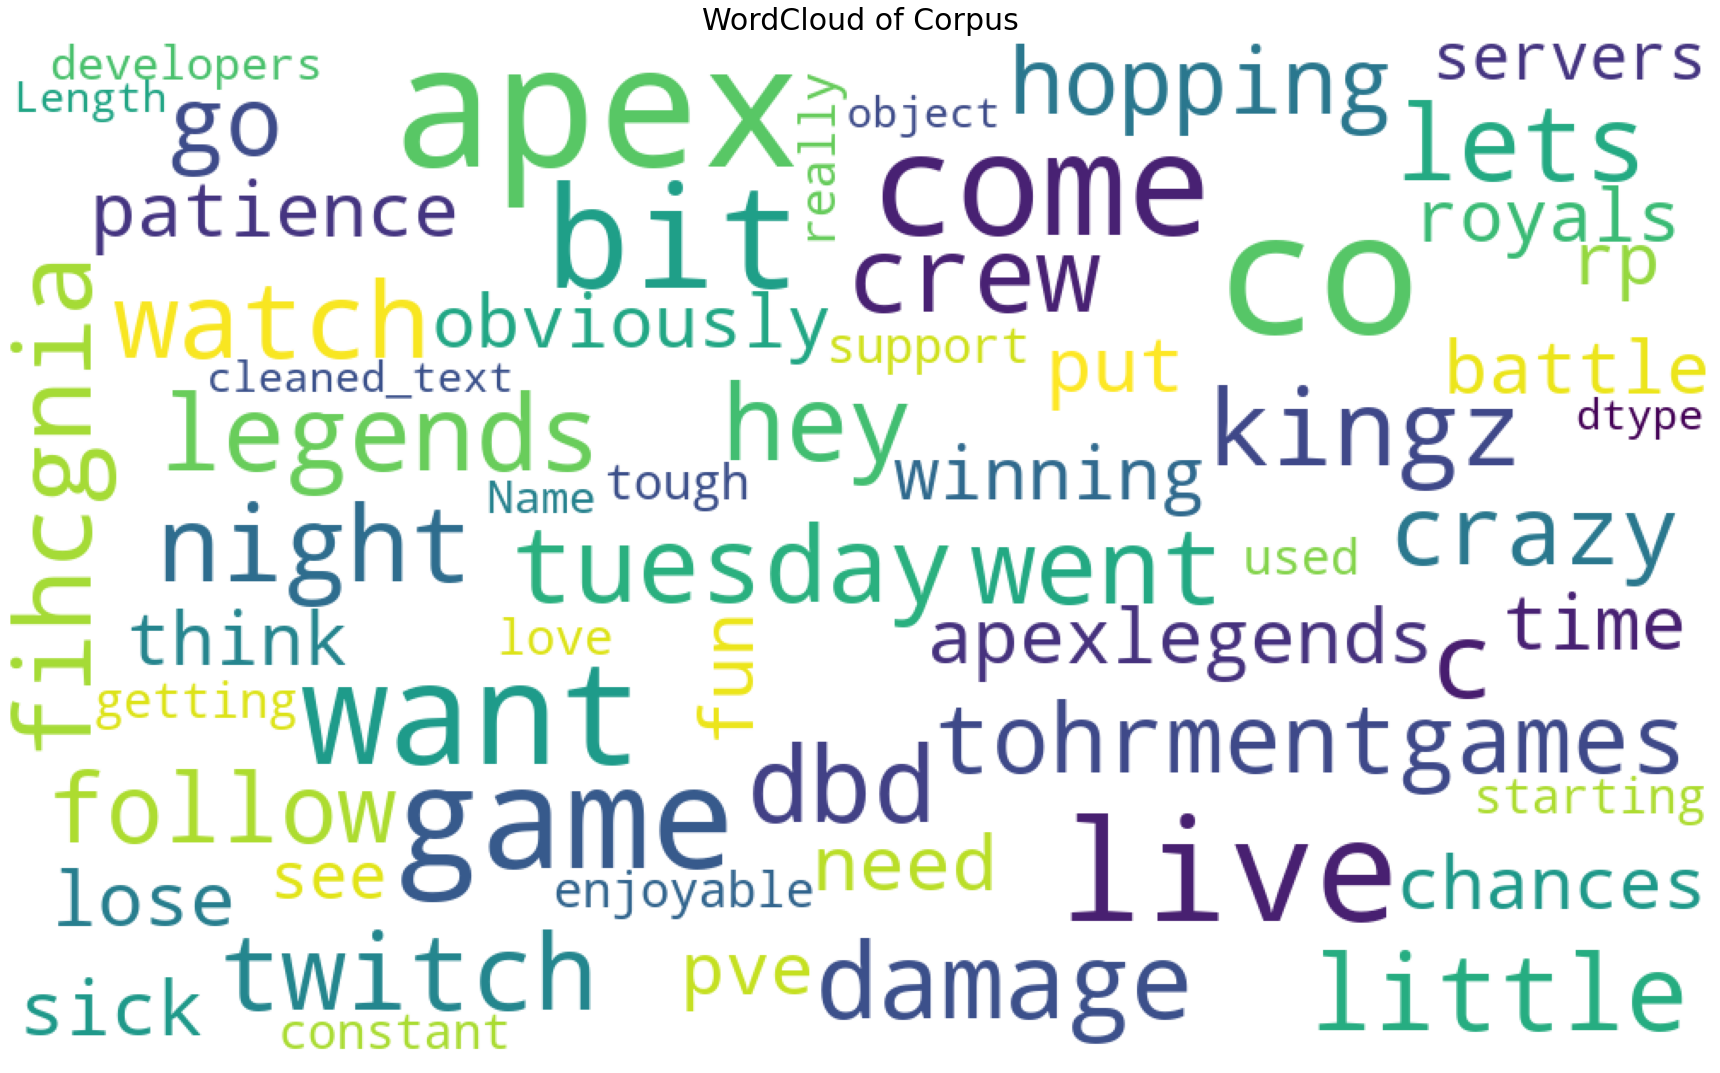

In [18]:
pos_mask = np.array(Image.new('RGB', (1000,600)))
plot_wordcloud(word_list_train, mask=pos_mask,color='white',max_font_size=100,title_size=30,title="WordCloud of Corpus")

<a id="vectorization"></a>
### [1.4. Vectorization](#content)

For training with classifiers, vectorization is necessary. We are also going to split dataset into train, validation & test in this section.

In [19]:
# don't consider uncleaned text for now (too much noise)
preprocessings = ['cleaned_stemmed_text', 'cleaned_lemmatized_text', 'cleaned_text'] 

In [20]:
sub_df = df[df['Subjectivity'].notna()].copy()
sub_df = sub_df.dropna(subset=preprocessings)
sub_df['Subjectivity'].value_counts()

1.0    15054
0.0     7337
Name: Subjectivity, dtype: int64

We can see that here the class is highly unbalanced with too many biased content. For better output, we need to balance the dataset first

In [21]:
# Random oversampling involves randomly selecting examples from the minority class, with replacement, and adding them to the training dataset.
# Random oversampling may cause overfitting to happen quite easily. We need to 
sampler = RandomUnderSampler(random_state=seed)
X_sub, Y_sub = sampler.fit_resample(sub_df[preprocessings], sub_df['Subjectivity'])
Y_sub.value_counts()

0.0    7337
1.0    7337
Name: Subjectivity, dtype: int64

In [22]:
# do the same for 'Polarity'
polar_df = df[df['Polarity'].notna()].copy()
polar_df = polar_df.dropna(subset=preprocessings)
polar_df['Polarity'].value_counts()

0.0    7710
1.0    7338
Name: Polarity, dtype: int64

In [23]:
X_polar, Y_polar = sampler.fit_resample(polar_df[preprocessings], polar_df['Polarity'])
Y_polar.value_counts()

0.0    7338
1.0    7338
Name: Polarity, dtype: int64

<b> Train, test, cv split </b>

After spliting, the ratio would be 0.64:0.16:0.2

In [24]:
# for subjectivity, get train set, valid set (cross validation), andn test set
X_train_valid_sub, X_test_sub, y_train_valid_sub, y_test_sub = train_test_split(X_sub, 
                                                    Y_sub,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=Y_sub)
X_train_sub, X_valid_sub, y_train_sub, y_valid_sub = train_test_split(X_train_valid_sub, 
                                                    y_train_valid_sub,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=y_train_valid_sub)

print(f"Shape of X_train: {X_train_sub.shape}")
print(f"Shape of y_train: {y_train_sub.shape}")
print(f"Shape of X_valid: {X_valid_sub.shape}")
print(f"Shape of y_valid: {y_valid_sub.shape}")
print(f"Shape of X_test: {X_test_sub.shape}")
print(f"Shape of y_test: {y_test_sub.shape}")

Shape of X_train: (9391, 3)
Shape of y_train: (9391,)
Shape of X_valid: (2348, 3)
Shape of y_valid: (2348,)
Shape of X_test: (2935, 3)
Shape of y_test: (2935,)


In [25]:
# for polarity, get train set, valid set (cross validation), andn test set
X_train_valid_polar, X_test_polar, y_train_valid_polar, y_test_polar = train_test_split(X_polar, 
                                                    Y_polar,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=Y_polar)
X_train_polar, X_valid_polar, y_train_polar, y_valid_polar = train_test_split(X_train_valid_polar, 
                                                    y_train_valid_polar,
                                                    test_size = 0.2, 
                                                    random_state = seed, stratify=y_train_valid_polar)

print(f"Shape of X_train: {X_train_polar.shape}")
print(f"Shape of y_train: {y_train_polar.shape}")
print(f"Shape of X_valid: {X_valid_polar.shape}")
print(f"Shape of y_valid: {y_valid_polar.shape}")
print(f"Shape of X_test: {X_test_polar.shape}")
print(f"Shape of y_test: {y_test_polar.shape}")

Shape of X_train: (9392, 3)
Shape of y_train: (9392,)
Shape of X_valid: (2348, 3)
Shape of y_valid: (2348,)
Shape of X_test: (2936, 3)
Shape of y_test: (2936,)


In [26]:
vec_X_train_sub = {}
vec_X_valid_sub = {}
vec_X_test_sub = {}
# The CountVectorizer will select the words/features/terms which occur the most frequently. It takes absolute values so if you set the 'max_features = 3', it will select the 3 most common words in the data.
for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_sub[method])
    X_train_cv =  clf.transform(X_train_sub[method])
    X_valid_cv = clf.transform(X_valid_sub[method])
    X_test_cv = clf.transform(X_test_sub[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_sub[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_sub[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_sub[method] = tf_transformer.transform(X_test_cv)

In [27]:
vec_X_train_polar = {}
vec_X_valid_polar = {}
vec_X_test_polar = {}

for method in preprocessings:
    clf = CountVectorizer(ngram_range=(1,2), max_features=500).fit(X_train_polar[method])
    X_train_cv =  clf.transform(X_train_polar[method])
    X_valid_cv = clf.transform(X_valid_polar[method])
    X_test_cv = clf.transform(X_test_polar[method])
    
    tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
    vec_X_train_polar[method] = tf_transformer.transform(X_train_cv)
    vec_X_valid_polar[method] = tf_transformer.transform(X_valid_cv)
    vec_X_test_polar[method] = tf_transformer.transform(X_test_cv)

<a id="classifiers"></a>
## [2. Classifiers](#content)

<a id="naive"></a>
### [2.1. Naive Bayes Classification](#content)

In [28]:
def naiveBayesClassification(x_train, x_test, y_train, y_test, preprocessing):

    naiveBayes_model = MultinomialNB().fit(x_train, y_train)
    result = naiveBayes_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Naive Bayes Classification")
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Naive Bayes Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score = metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)
    
    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()

<a id="KNN"></a>
### [2.2. K-Nearest Neighbour (KNN) Classification](#content)

In [29]:
def KNNClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):

    if best_params is None:
        
        print("Grid searching best parameters for KNN")

        metric = ['euclidean', 'manhattan', 'cosine']
        neighbors = list(range(10,30))
        leaf_size = list(range(1,10))
        weight = ['uniform', 'distance']
        param_grid = {'metric' : metric, 'n_neighbors': neighbors, 'weights' : weight, 'leaf_size' : leaf_size}
        
        grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_
    
    
    knn_model = KNeighborsClassifier(n_neighbors = best_params['n_neighbors'], metric= best_params['metric'], leaf_size = best_params['leaf_size'], weights = best_params['weights'])
    knn_model.fit(x_train, y_train)   
    
    result = knn_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: K-Nearest Neighbour Classification")
    print("Best parameters:", best_params)
    print("Preprocessing Function: ", preprocessing)
    print("==================================================")
    print()
    plt.title("Confusion matrix of KNN Classification of tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
    return best_params
  

<a id="SVM"></a>
### [2.3. Support Vector Machine (SVM) Classification](#content)

In [30]:
def SVMClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None, save_model=False):

    if best_params is None:
        
        print("Grid searching best parameters for SVM")

        Cs = [0.001, 0.01, 0.1, 1, 10]
        gammas = [0.05, 0.1, 0.15, 0.20, 0.25]
        degrees = [0, 1, 2, 3, 4, 5, 6]
        kernels = ['rbf', 'linear', 'poly']
        param_grid = {'C': Cs, 'gamma' : gammas, 'degree' : degrees, 'kernel' : kernels}
        
        grid_search = GridSearchCV(svm.SVC(), param_grid, cv = 3)
        grid_search.fit(x_valid, y_valid)

        best_params = grid_search.best_params_

    SVM_model = svm.SVC(C = best_params['C'], kernel = best_params['kernel'], gamma = best_params['gamma'], degree = best_params['degree'], random_state=seed)
    SVM_model.fit(x_train, y_train)
    
    result = SVM_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)
    
    
    # ==================================================
    # Confusion Matrix
    # ==================================================
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Support Vector Machine Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of SVM Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    
    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
    return best_params
    

<a id="DT"></a>
### [2.4. Decision Tree Classification](#content)

In [31]:
def decisionTreeClassification(x_train, x_valid, x_test, y_train, y_valid, y_test, preprocessing, best_params=None):
    
    clf = DecisionTreeClassifier() 

    if best_params is None:
            
        print("Grid searching best parameters for decision tree")
        param_grid = { 
            'criterion': ['gini','entropy'],
            'splitter': ['best','random'],
            'max_features': ['sqrt','log2']
        }
        
        grid_search = GridSearchCV(clf, param_grid, cv= 3)
        grid_search.fit(x_valid, y_valid)
        best_params = grid_search.best_params_

    decisionTree_model = DecisionTreeClassifier(criterion = best_params['criterion'],splitter = best_params['splitter'], max_features = best_params['max_features'], random_state=seed)
    decisionTree_model.fit(x_train, y_train)

    result = decisionTree_model.predict(x_test)
    confuse = metrics.confusion_matrix(y_test, result)


    # ==================================================
    # Confusion Matrix
    # ==================================================
    
    fig = plt.figure()
    sns.heatmap(confuse, annot = True, fmt='d')
    
    print("==================================================")
    print("Model: Decision Tree Classification")
    print("Preprocessing Function: ", preprocessing)
    print("Best parameters:", best_params)
    print("==================================================")
    print()
    plt.title("Confusion matrix of Decision Tree Classification of Tweets")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ==================================================
    # Evaluation Metrics
    # ==================================================
    
    F1_score = metrics.f1_score(y_test, result)
    precision_score= metrics.precision_score(y_test, result)
    recall_score = metrics.recall_score(y_test, result)
    average_precision = metrics.average_precision_score(y_test, result)

    print("------------ Evaluation Metrics ----------------")
    print()
    print('F1 score: {0:0.3f}'.format(F1_score))
    print('Precision score: {0:0.3f}'.format(precision_score))
    print('Recall score: {0:0.3f}'.format(recall_score))
    print('Average precision-recall score: {0:0.3f}'.format(average_precision))
    print()
    return best_params

<a id="training"></a>
## [3. Training & Evaluation](#content)

<a id="subjectivity"></a>
### [3.1. Subjectivity Classification & Evaluation](#content)

We use naive bayes model's performance as the baseline for measurements of other models.

In [32]:
best_params_list = []

if os.path.exists('best_params.tsv'):
    best_params_df = pd.read_csv("best_params.tsv", sep='\t')
else:
    best_params_df = None

In [33]:
def get_best_params(model_name: str, task: str, src:str):
    if best_params_df is None:
        return None
    param = best_params_df[(best_params_df['model'] == model_name) & (best_params_df['task']==task) & (best_params_df['input'] == src)]['best_params'].values[0]
    try:
        return ast.literal_eval(param)
    except:
        return None

**Best parameters are saved to local file beforehand, allow fast reproduction of results.**    <br>
To disable reading trained parameters, simply remove (or move) the file 'best_params.tsv' from notebook's folder

In [34]:
def base_line_performance(processing_idx:int, task: str):
    print("Base line")
    method = preprocessings[processing_idx]
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_test = y_test_polar
        
    naiveBayesClassification(x_train, x_test, y_train, y_test, method)

In [35]:
def classifier_performance(processing_idx:int, task: str):
    method = preprocessings[processing_idx]
    params_dict = {'model':[], 'task':[task]*3, 'input':[method]*3, 'best_params':[]}
    if task == 'subjectivity':
        x_train = vec_X_train_sub[method]
        x_valid = vec_X_valid_sub[method]
        x_test = vec_X_test_sub[method]
        y_train = y_train_sub
        y_valid = y_valid_sub
        y_test = y_test_sub
    else:
        x_train = vec_X_train_polar[method]
        x_valid = vec_X_valid_polar[method]
        x_test = vec_X_test_polar[method]
        y_train = y_train_polar
        y_valid = y_valid_polar
        y_test = y_test_polar

    tree_params = decisionTreeClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('DecisionTree', task, method))
    
    params_dict['model'].append('DecisionTree')
    params_dict['best_params'].append(tree_params)
    
    svm_params = SVMClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('SVM', task, method)
    )
    
    params_dict['model'].append('SVM')
    params_dict['best_params'].append(svm_params)
    
    knn_params = KNNClassification(
        x_train,
        x_valid,
        x_test,
        y_train,
        y_valid,
        y_test,
        method, 
        get_best_params('KNN', task, method)
    )
    
    params_dict['model'].append('KNN')
    params_dict['best_params'].append(knn_params)
    
    return params_dict

#### 3.1.1 Subjectivity with Cleaned Stemmed Text
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



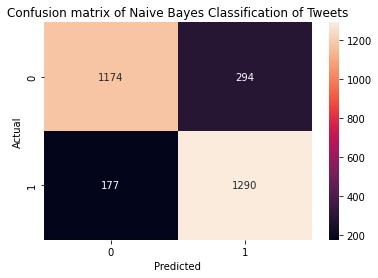

------------ Evaluation Metrics ----------------

F1 score: 0.846
Precision score: 0.814
Recall score: 0.879
Average precision-recall score: 0.776



In [36]:
base_line_performance(0,'subjectivity')

Grid searching best parameters for decision tree
Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



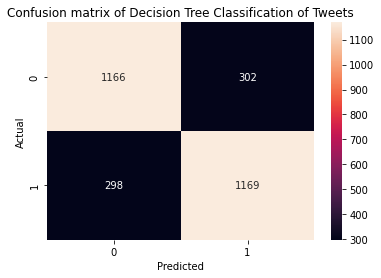

------------ Evaluation Metrics ----------------

F1 score: 0.796
Precision score: 0.795
Recall score: 0.797
Average precision-recall score: 0.735

Grid searching best parameters for SVM
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 1, 'degree': 1, 'gamma': 0.15, 'kernel': 'poly'}



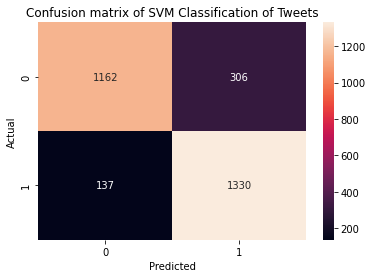

------------ Evaluation Metrics ----------------

F1 score: 0.857
Precision score: 0.813
Recall score: 0.907
Average precision-recall score: 0.784

Grid searching best parameters for KNN
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 25, 'weights': 'distance'}
Preprocessing Function:  cleaned_stemmed_text



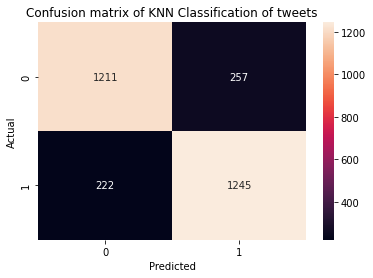

------------ Evaluation Metrics ----------------

F1 score: 0.839
Precision score: 0.829
Recall score: 0.849
Average precision-recall score: 0.779



In [37]:
best_params = classifier_performance(0,'subjectivity')
best_params_list.append(pd.DataFrame(best_params))

#### 3.1.2 Subjectivity with Cleaned Lemmatized Text 
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



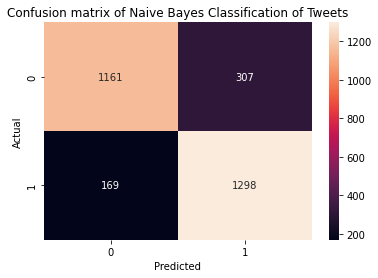

------------ Evaluation Metrics ----------------

F1 score: 0.845
Precision score: 0.809
Recall score: 0.885
Average precision-recall score: 0.773



In [38]:
base_line_performance(1,'subjectivity')

Grid searching best parameters for decision tree
Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'gini', 'max_features': 'sqrt', 'splitter': 'best'}



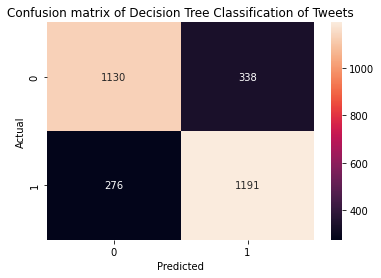

------------ Evaluation Metrics ----------------

F1 score: 0.795
Precision score: 0.779
Recall score: 0.812
Average precision-recall score: 0.726

Grid searching best parameters for SVM
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.15, 'kernel': 'rbf'}



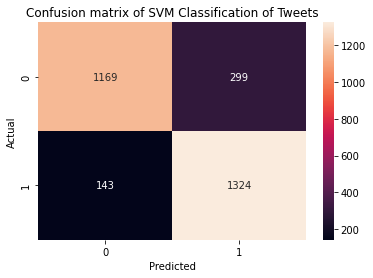

------------ Evaluation Metrics ----------------

F1 score: 0.857
Precision score: 0.816
Recall score: 0.903
Average precision-recall score: 0.785

Grid searching best parameters for KNN
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 25, 'weights': 'distance'}
Preprocessing Function:  cleaned_lemmatized_text



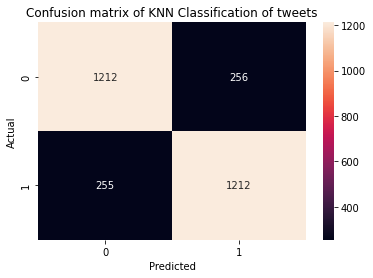

------------ Evaluation Metrics ----------------

F1 score: 0.826
Precision score: 0.826
Recall score: 0.826
Average precision-recall score: 0.769



In [39]:
best_params2 = classifier_performance(1,'subjectivity')
best_params_list.append(pd.DataFrame(best_params2))

#### 3.1.3 Subjectivity with Cleaned Text 
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



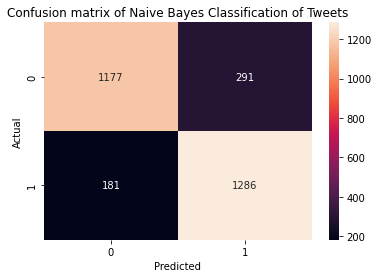

------------ Evaluation Metrics ----------------

F1 score: 0.845
Precision score: 0.815
Recall score: 0.877
Average precision-recall score: 0.777



In [40]:
base_line_performance(2, 'subjectivity')

Grid searching best parameters for decision tree
Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



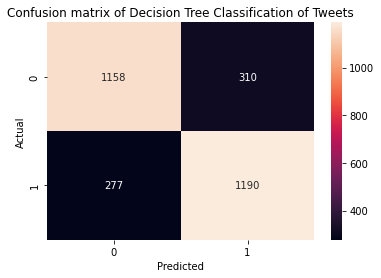

------------ Evaluation Metrics ----------------

F1 score: 0.802
Precision score: 0.793
Recall score: 0.811
Average precision-recall score: 0.738

Grid searching best parameters for SVM
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.1, 'kernel': 'rbf'}



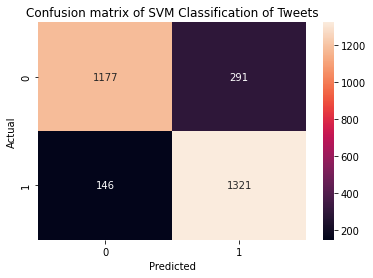

------------ Evaluation Metrics ----------------

F1 score: 0.858
Precision score: 0.819
Recall score: 0.900
Average precision-recall score: 0.788

Grid searching best parameters for KNN
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 26, 'weights': 'distance'}
Preprocessing Function:  cleaned_text



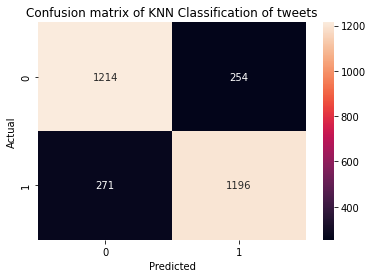

------------ Evaluation Metrics ----------------

F1 score: 0.820
Precision score: 0.825
Recall score: 0.815
Average precision-recall score: 0.765



In [41]:
best_params3 = classifier_performance(2, 'subjectivity')
best_params_list.append(pd.DataFrame(best_params3))

#### Save SVM model

In [42]:
SVM_param = pd.DataFrame(best_params3).loc[pd.DataFrame(best_params3)['model']=='SVM']['best_params'].values[0]
SVM_model = svm.SVC(C = SVM_param['C'], kernel = SVM_param['kernel'], gamma = SVM_param['gamma'], degree = SVM_param['degree'], random_state=seed)
SVM_model.fit(vec_X_train_sub['cleaned_text'], y_train_sub)
if os.path.exists('svm_subjectivity_model.sav'):
    os.remove('svm_subjectivity_model.sav')
pickle.dump(SVM_model, open('svm_subjectivity_model.sav', 'wb'))

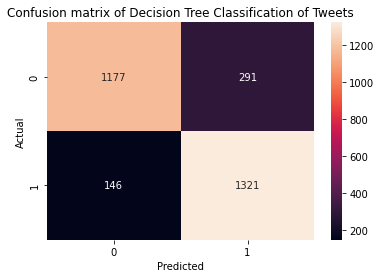

------------ Evaluation Metrics ----------------

F1 score: 0.858
Precision score: 0.819
Recall score: 0.900
Average precision-recall score: 0.788



In [43]:
# verify that model is correctly saved

x_test = vec_X_test_sub['cleaned_text']
y_test = y_test_sub

loaded_model = pickle.load(open('svm_subjectivity_model.sav', 'rb'))
result = loaded_model.predict(x_test)
confuse = metrics.confusion_matrix(y_test, result)

fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of Tweets")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

F1_score = metrics.f1_score(y_test, result)
precision_score= metrics.precision_score(y_test, result)
recall_score = metrics.recall_score(y_test, result)
average_precision = metrics.average_precision_score(y_test, result)

print("------------ Evaluation Metrics ----------------")
print()
print('F1 score: {0:0.3f}'.format(F1_score))
print('Precision score: {0:0.3f}'.format(precision_score))
print('Recall score: {0:0.3f}'.format(recall_score))
print('Average precision-recall score: {0:0.3f}'.format(average_precision))
print()

<a id="polarity"></a>
### [3.2. Polarity Classification & Evaluation](#content)

We use naive bayes model's performance as the baseline for measurements of other models.

#### 3.2.1 Polarity with Cleaned Stemmed Text
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_stemmed_text



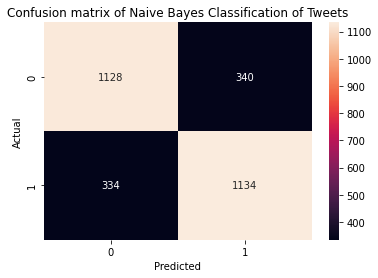

------------ Evaluation Metrics ----------------

F1 score: 0.771
Precision score: 0.769
Recall score: 0.772
Average precision-recall score: 0.708



In [44]:
base_line_performance(0,'polarity')

Grid searching best parameters for decision tree
Model: Decision Tree Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'best'}



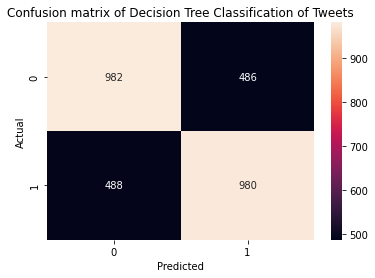

------------ Evaluation Metrics ----------------

F1 score: 0.668
Precision score: 0.668
Recall score: 0.668
Average precision-recall score: 0.612

Grid searching best parameters for SVM
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_stemmed_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.2, 'kernel': 'rbf'}



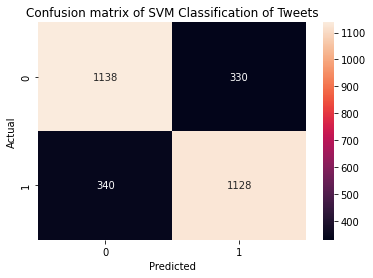

------------ Evaluation Metrics ----------------

F1 score: 0.771
Precision score: 0.774
Recall score: 0.768
Average precision-recall score: 0.710

Grid searching best parameters for KNN
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 27, 'weights': 'uniform'}
Preprocessing Function:  cleaned_stemmed_text



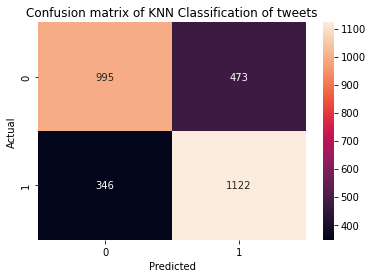

------------ Evaluation Metrics ----------------

F1 score: 0.733
Precision score: 0.703
Recall score: 0.764
Average precision-recall score: 0.655



In [45]:
best_params4 = classifier_performance(0,'polarity')
best_params_list.append(pd.DataFrame(best_params4))

#### 3.2.2 Polarity with Cleaned Lemmatized Text
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_lemmatized_text



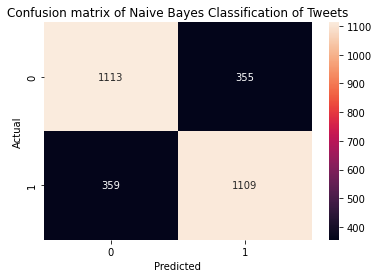

------------ Evaluation Metrics ----------------

F1 score: 0.756
Precision score: 0.758
Recall score: 0.755
Average precision-recall score: 0.695



In [46]:
base_line_performance(1,'polarity')

Grid searching best parameters for decision tree
Model: Decision Tree Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}



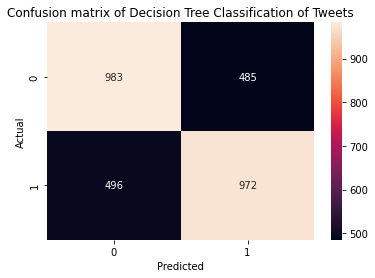

------------ Evaluation Metrics ----------------

F1 score: 0.665
Precision score: 0.667
Recall score: 0.662
Average precision-recall score: 0.611

Grid searching best parameters for SVM
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_lemmatized_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.2, 'kernel': 'rbf'}



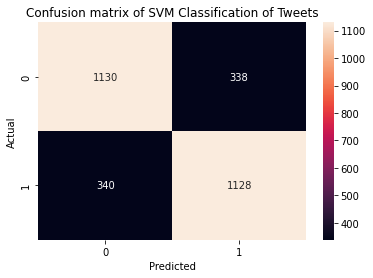

------------ Evaluation Metrics ----------------

F1 score: 0.769
Precision score: 0.769
Recall score: 0.768
Average precision-recall score: 0.707

Grid searching best parameters for KNN
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 29, 'weights': 'uniform'}
Preprocessing Function:  cleaned_lemmatized_text



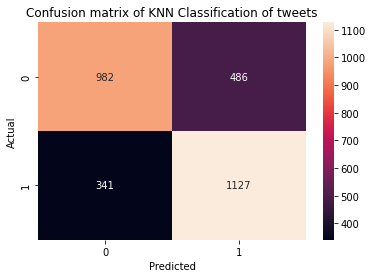

------------ Evaluation Metrics ----------------

F1 score: 0.732
Precision score: 0.699
Recall score: 0.768
Average precision-recall score: 0.653



In [47]:
best_params5 = classifier_performance(1,'polarity')
best_params_list.append(pd.DataFrame(best_params5))

#### 3.2.3 Polarity with Cleaned Text 
Compare what we have with baseline model (Naive Bayes)

Base line
Model: Naive Bayes Classification
Preprocessing Function:  cleaned_text



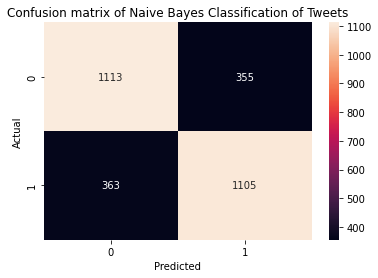

------------ Evaluation Metrics ----------------

F1 score: 0.755
Precision score: 0.757
Recall score: 0.753
Average precision-recall score: 0.693



In [48]:
base_line_performance(2, 'polarity')

Grid searching best parameters for decision tree
Model: Decision Tree Classification
Preprocessing Function:  cleaned_text
Best parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'splitter': 'random'}



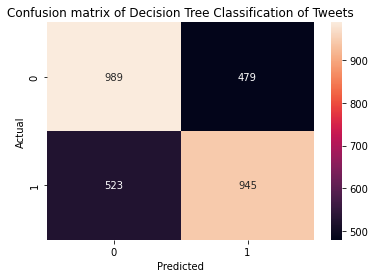

------------ Evaluation Metrics ----------------

F1 score: 0.654
Precision score: 0.664
Recall score: 0.644
Average precision-recall score: 0.605

Grid searching best parameters for SVM
Model: Support Vector Machine Classification
Preprocessing Function:  cleaned_text
Best parameters: {'C': 1, 'degree': 0, 'gamma': 0.1, 'kernel': 'rbf'}



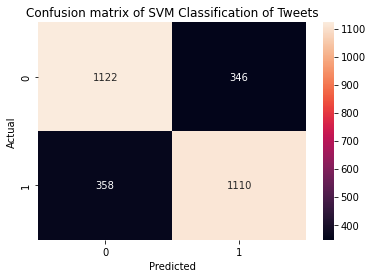

------------ Evaluation Metrics ----------------

F1 score: 0.759
Precision score: 0.762
Recall score: 0.756
Average precision-recall score: 0.698

Grid searching best parameters for KNN
Model: K-Nearest Neighbour Classification
Best parameters: {'leaf_size': 1, 'metric': 'cosine', 'n_neighbors': 29, 'weights': 'distance'}
Preprocessing Function:  cleaned_text



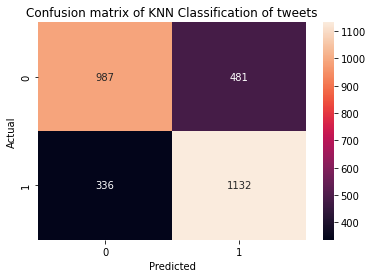

------------ Evaluation Metrics ----------------

F1 score: 0.735
Precision score: 0.702
Recall score: 0.771
Average precision-recall score: 0.656



In [49]:
best_params6 = classifier_performance(2, 'polarity')
best_params_list.append(pd.DataFrame(best_params6))

#### Save SVM Model

In [50]:
SVM_param = pd.DataFrame(best_params6).loc[pd.DataFrame(best_params6)['model']=='SVM']['best_params'].values[0]
SVM_polar_model = svm.SVC(C = SVM_param['C'], kernel = SVM_param['kernel'], gamma = SVM_param['gamma'], degree = SVM_param['degree'], random_state=seed)
SVM_polar_model.fit(vec_X_train_polar['cleaned_text'], y_train_polar)
if os.path.exists('svm_polarity_model.sav'):
    os.remove('svm_polarity_model.sav')
pickle.dump(SVM_polar_model, open('svm_polarity_model.sav', 'wb'))

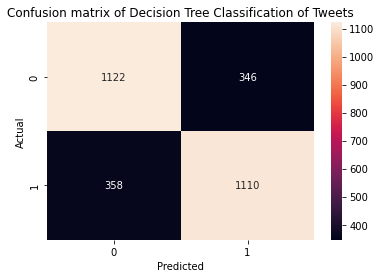

------------ Evaluation Metrics ----------------

F1 score: 0.759
Precision score: 0.762
Recall score: 0.756
Average precision-recall score: 0.698



In [51]:
# verify that model is correctly saved

x_test = vec_X_test_polar['cleaned_text']
y_test = y_test_polar

loaded_model = pickle.load(open('svm_polarity_model.sav', 'rb'))
result = loaded_model.predict(x_test)
confuse = metrics.confusion_matrix(y_test, result)

fig = plt.figure()
sns.heatmap(confuse, annot = True, fmt='d')
plt.title("Confusion matrix of Decision Tree Classification of Tweets")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

F1_score = metrics.f1_score(y_test, result)
precision_score= metrics.precision_score(y_test, result)
recall_score = metrics.recall_score(y_test, result)
average_precision = metrics.average_precision_score(y_test, result)

print("------------ Evaluation Metrics ----------------")
print()
print('F1 score: {0:0.3f}'.format(F1_score))
print('Precision score: {0:0.3f}'.format(precision_score))
print('Recall score: {0:0.3f}'.format(recall_score))
print('Average precision-recall score: {0:0.3f}'.format(average_precision))
print()

#### Concatenate parameters and save them

In [52]:
if best_params_df is None:
    print("Saving parameters to 'best_params.tsv'")
    merge_df = pd.concat(best_params_list)
    merge_df.to_csv('best_params.tsv', sep='\t', index=False)

Saving parameters to 'best_params.tsv'


<a id="bert"></a>
## [Innovation: Traditionoal Classifiers vs Bert](#content)

In [53]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8' 

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [54]:
def plot_training_epoch(history, acc_label='binary_accuracy', acc_val_label='val_binary_accuracy', loss_label='loss', loss_val_label='val_loss'):
    history_dict = history.history
    print(history_dict.keys())

    acc = history_dict[acc_label]
    val_acc = history_dict[acc_val_label]
    loss = history_dict[loss_label]
    val_loss = history_dict[loss_val_label]

    epochs = range(1, len(acc) + 1)
    fig = plt.figure(figsize=(10, 6))
    fig.tight_layout()

    plt.subplot(2, 1, 1)
    # r is for "solid red line"
    plt.plot(epochs, loss, 'r', label='Training loss')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    # plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

In [55]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(5,5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Blues", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Test', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()
    print('\tClassification Report for BERT:\n\n',classification_report(y, y_pred, target_names=labels))

In [56]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Raw Model 

**Rationale behind using cleaned_text for BERT:**<br>
Bert uses BPE (Byte- Pair Encoding to shrink its vocab size), so words like run and running will ultimately be decoded to run + ##ing. That's why it's better not to convert running into run because, in some NLP problems, that information is needed.

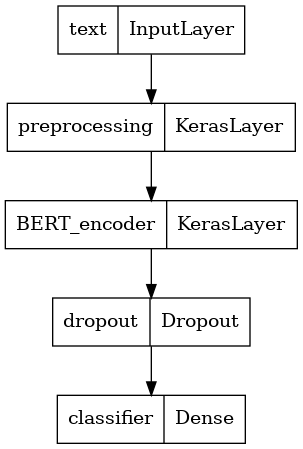

In [57]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

In [58]:
bert_raw_result = classifier_model(np.array(X_test_sub['cleaned_text']))

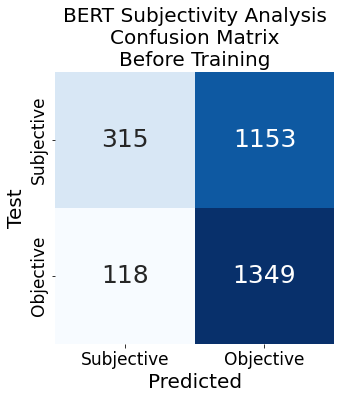

	Classification Report for BERT:

               precision    recall  f1-score   support

  Subjective       0.73      0.21      0.33      1468
   Objective       0.54      0.92      0.68      1467

    accuracy                           0.57      2935
   macro avg       0.63      0.57      0.51      2935
weighted avg       0.63      0.57      0.51      2935



In [59]:
conf_matrix(y_test_sub.astype(bool), K.round(tf.sigmoid(bert_raw_result)),'BERT Subjectivity Analysis\nConfusion Matrix\nBefore Training', ['Subjective', 'Objective'])

### Training Model for Subjectivity

In [60]:
def get_optimizer(steps_per_epoch, epochs=5, batch_size=32, init_lr = 3e-5):
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)
    return optimization.create_optimizer(init_lr=init_lr,num_train_steps=num_train_steps,num_warmup_steps=num_warmup_steps,optimizer_type='adamw')

In [61]:
sub_model = build_classifier_model()

epochs=25
batch_size=32

sub_model.compile(optimizer=get_optimizer(epochs=epochs,steps_per_epoch=len(X_train_sub['cleaned_text'])/batch_size),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=tf.metrics.BinaryAccuracy())

# use early stopping to avoid overfitting problem
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

history = sub_model.fit(np.array(X_train_sub['cleaned_text']), y_train_sub, 
                               validation_data=(np.array(X_valid_sub['cleaned_text']), y_valid_sub), 
                               epochs=epochs, batch_size=batch_size, callbacks =[earlystopping])  # Pass callback to training

Epoch 1/25
294/294 [==============================] - 62s 192ms/step - loss: 0.5034 - binary_accuracy: 0.7267 - val_loss: 0.3507 - val_binary_accuracy: 0.8275
Epoch 2/25
294/294 [==============================] - 55s 187ms/step - loss: 0.3449 - binary_accuracy: 0.8266 - val_loss: 0.3358 - val_binary_accuracy: 0.8373
Epoch 3/25
294/294 [==============================] - 55s 188ms/step - loss: 0.2932 - binary_accuracy: 0.8581 - val_loss: 0.2965 - val_binary_accuracy: 0.8492
Epoch 4/25
294/294 [==============================] - 55s 188ms/step - loss: 0.2330 - binary_accuracy: 0.8917 - val_loss: 0.3031 - val_binary_accuracy: 0.8620
Epoch 5/25
294/294 [==============================] - 55s 189ms/step - loss: 0.1767 - binary_accuracy: 0.9221 - val_loss: 0.3704 - val_binary_accuracy: 0.8595
Epoch 6/25
294/294 [==============================] - 55s 188ms/step - loss: 0.1142 - binary_accuracy: 0.9527 - val_loss: 0.4545 - val_binary_accuracy: 0.8526
Epoch 7/25
294/294 [==========================

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


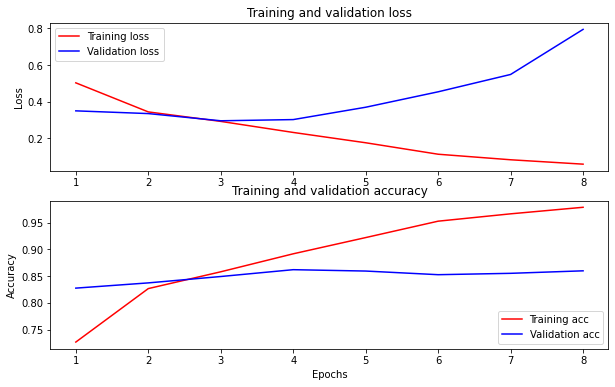

In [62]:
plot_training_epoch(history)

In [63]:
loss, accuracy = sub_model.evaluate(np.array(X_test_sub['cleaned_text']), y_test_sub)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

92/92 [==============================] - 9s 97ms/step - loss: 0.2967 - binary_accuracy: 0.8484
Loss: 0.2966790199279785
Accuracy: 0.8483815789222717


In [64]:
y_pred_sub = sub_model.predict(np.array(X_test_sub['cleaned_text']))

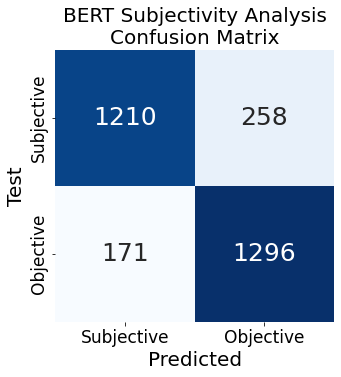

	Classification Report for BERT:

               precision    recall  f1-score   support

  Subjective       0.88      0.82      0.85      1468
   Objective       0.83      0.88      0.86      1467

    accuracy                           0.85      2935
   macro avg       0.86      0.85      0.85      2935
weighted avg       0.86      0.85      0.85      2935



In [65]:
conf_matrix(y_test_sub.astype(bool), K.round(tf.sigmoid(y_pred_sub)),'BERT Subjectivity Analysis\nConfusion Matrix', ['Subjective', 'Objective'])

In [66]:
if os.path.exists('./bert_subjectivity_model'):
    shutil.rmtree('./bert_subjectivity_model')
if os.path.exists('bert_subjectivity_model.zip'):
    os.remove('bert_subjectivity_model.zip')

In [67]:
# save the model for future use
sub_model.save('./bert_subjectivity_model', include_optimizer=False)
shutil.make_archive('bert_subjectivity_model', 'zip', './bert_subjectivity_model') # for easier distribution

2022-11-04 06:00:03.672449: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


'/kaggle/working/bert_subjectivity_model.zip'

### Train Model for Polarity

We are going to use Binary Cross Entropy loss function

In [68]:
polar_model = build_classifier_model()

epochs=15
batch_size=32

polar_model.compile(optimizer=get_optimizer(epochs=epochs,steps_per_epoch=len(X_train_polar['cleaned_text'])/batch_size),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=tf.metrics.BinaryAccuracy())

# avoid overfitting
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

polar_history = polar_model.fit(np.array(X_train_polar['cleaned_text']), y_train_polar, 
                               validation_data=(np.array(X_valid_polar['cleaned_text']), y_valid_polar), 
                               epochs=epochs, batch_size=batch_size, callbacks =[earlystopping])  # Pass callback to training

Epoch 1/15
294/294 [==============================] - 63s 192ms/step - loss: 0.6052 - binary_accuracy: 0.6494 - val_loss: 0.5004 - val_binary_accuracy: 0.7760
Epoch 2/15
294/294 [==============================] - 56s 190ms/step - loss: 0.4609 - binary_accuracy: 0.7789 - val_loss: 0.4464 - val_binary_accuracy: 0.7896
Epoch 3/15
294/294 [==============================] - 56s 189ms/step - loss: 0.3798 - binary_accuracy: 0.8233 - val_loss: 0.4532 - val_binary_accuracy: 0.7934
Epoch 4/15
294/294 [==============================] - 55s 188ms/step - loss: 0.2994 - binary_accuracy: 0.8690 - val_loss: 0.4667 - val_binary_accuracy: 0.8105
Epoch 5/15
294/294 [==============================] - 56s 190ms/step - loss: 0.2271 - binary_accuracy: 0.9065 - val_loss: 0.5457 - val_binary_accuracy: 0.8092
Epoch 6/15
294/294 [==============================] - 56s 190ms/step - loss: 0.1779 - binary_accuracy: 0.9246 - val_loss: 0.6184 - val_binary_accuracy: 0.8054
Epoch 7/15
294/294 [==========================

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


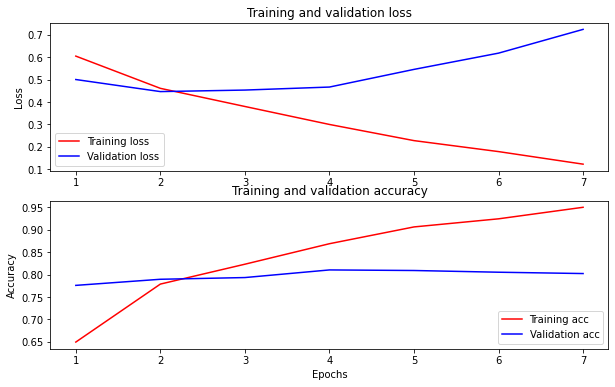

In [69]:
plot_training_epoch(polar_history)

In [70]:
loss, accuracy = polar_model.evaluate(np.array(X_test_polar['cleaned_text']), y_test_polar)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

92/92 [==============================] - 9s 95ms/step - loss: 0.4315 - binary_accuracy: 0.7950
Loss: 0.4315412938594818
Accuracy: 0.7949591279029846


In [71]:
y_pred_polar = polar_model.predict(np.array(X_test_polar['cleaned_text']))

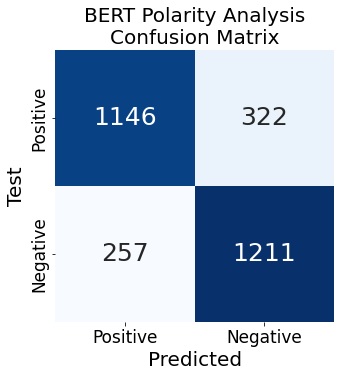

	Classification Report for BERT:

               precision    recall  f1-score   support

    Positive       0.82      0.78      0.80      1468
    Negative       0.79      0.82      0.81      1468

    accuracy                           0.80      2936
   macro avg       0.80      0.80      0.80      2936
weighted avg       0.80      0.80      0.80      2936



In [72]:
conf_matrix(y_test_polar.astype(bool), K.round(tf.sigmoid(y_pred_polar)),'BERT Polarity Analysis\nConfusion Matrix', ['Positive', 'Negative'])

In [73]:
if os.path.exists('./bert_polarity_model'):
    shutil.rmtree('./bert_polarity_model')
if os.path.exists('bert_polarity_model.zip'):
    os.remove('bert_polarity_model.zip')

In [74]:
# save the model for future use
polar_model.save('./bert_polarity_model', include_optimizer=False)
# import shutil
shutil.make_archive('bert_polarity_model', 'zip', './bert_polarity_model')

'/kaggle/working/bert_polarity_model.zip'